In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [2]:
def split_text_label(filename):
  f = open(filename)
  split_labelled_text = []
  sentence = []
  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=='\n':
      if len(sentence)<60 and len(sentence)>10:
        split_labelled_text.append(sentence)
        sentence = []
      continue
    splits = line.split(' ')
    sentence.append([splits[0].lower(),splits[-1].rstrip("\n")])

  if len(sentence)<60 and len(sentence)>10:
    split_labelled_text.append(sentence)
    sentence = []
  return split_labelled_text

In [3]:
split_train = split_text_label("conllpp_train.txt")
split_test = split_text_label("conllpp_test.txt")
split_dev = split_text_label("conllpp_dev.txt")

In [4]:
print(len(split_train))
split_train = split_train + split_dev
print(len(split_train))

1409
2115


In [5]:
print(len(split_dev))
split_train[0]

706


[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O'],
 ['peter', 'B-PER'],
 ['blackburn', 'I-PER']]

In [6]:
sentences = [[ word[0] for word in sentence] for sentence in split_train]

In [7]:
sentences[0]

['eu',
 'rejects',
 'german',
 'call',
 'to',
 'boycott',
 'british',
 'lamb',
 '.',
 'peter',
 'blackburn']

In [8]:
labels = [[word[1] for word in sentence] for sentence in split_train]

In [9]:
labels[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER', 'I-PER']

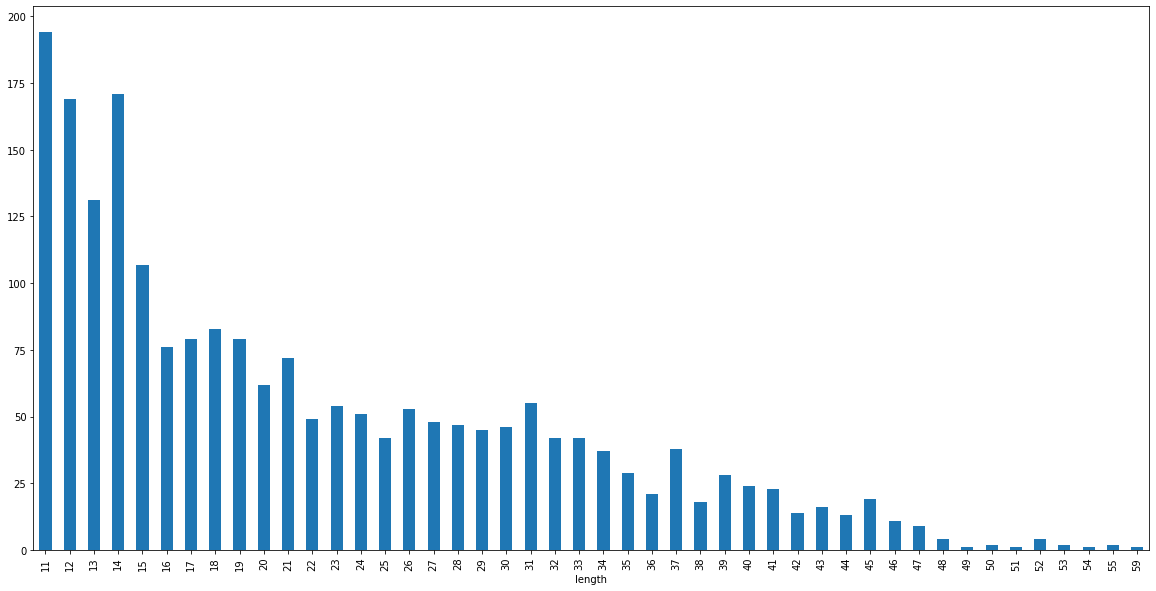

In [10]:
import matplotlib.pyplot as plt

l = [[1,len(sent)] for sent in sentences]
df = pd.DataFrame(l,columns=["sentence","length"])

fig = plt.figure(figsize=(20,10))
df.groupby(['length']).size().plot(kind = "bar")

In [11]:
def tag_index(filename):
  tag_idx = []
  f = open(filename)
  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=='\n':
      continue
    splits = line.split(' ')
    tag_idx.append(splits[-1].rstrip("\n"))

  tag_values = list(set(tag_idx))
  sorted_values = sorted(tag_values,key=len)
  tag2idx = {t: i for i, t in enumerate(sorted_values)}
  return tag2idx

In [12]:
tag2idx = tag_index("/content/conllpp_train.txt")

In [13]:
tag2idx

{'O': 0,
 'I-ORG': 1,
 'I-PER': 2,
 'B-LOC': 3,
 'B-PER': 4,
 'I-LOC': 5,
 'B-ORG': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.9 MB/s 
     |████████████████████████████████| 7.6 MB 64.5 MB/s 
     |████████████████████████████████| 182 kB 75.1 MB/s 


In [15]:
from transformers import BertTokenizer , TFBertModel

In [16]:
t=BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
t.tokenize("hashing")

['hash', '##ing']

In [18]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = t.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [19]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

In [20]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [21]:
max_len = 60

In [22]:
def bert_encode(tokenized_texts,labels):
  all_tokens = []
  all_masks = []
  all_segments = []

  for text in tokenized_texts:
    if len(text)>max_len-2:
      text = text[:max_len-2]
    input_sequence = ["[CLS]"]+text+["[SEP]"]
    pad_len = max_len-len(input_sequence)
    tokens = t.convert_tokens_to_ids(input_sequence) + [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len
    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

  return np.array(all_tokens),np.array(all_masks),np.array(all_segments)

In [23]:
train_input1,train_input2,train_input3 = bert_encode(tokenized_texts,labels)

In [24]:
train_input1[0]

array([  101,  7327, 19164,  2446,  2655,  2000, 17757,  2329, 12559,
        1012,  2848, 13934,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [25]:
train_input2[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
train_input3[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
#from keras.preprocessing.sequence import pad_sequences
tags = tf.keras.preprocessing.sequence.pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [30]:
tags[0]

array([6, 0, 7, 0, 0, 0, 7, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Dropout,Input,Bidirectional,GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [32]:
#with tpu_strategy.scope():
bert_model=TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
def build_model(max_len=512):
    #with tpu_strategy.scope():
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  
    emb=bert_model(input_word_ids,attention_mask=input_mask)[0]
  
    l=Bidirectional(LSTM(128,return_sequences=True))(emb)
    l=Bidirectional(LSTM(128,return_sequences=True))(l)
    l=Dense(256,activation='relu')(l)
    l = Dense(128,activation='relu')(l)
    l=Dropout(0.5)(l)
    l=Dense(len(tag2idx),activation='softmax')(l)
    
    model = Model(inputs=[input_word_ids, input_mask], outputs=l)
    return model

In [34]:
model = build_model(max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [35]:
#with tpu_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])


In [36]:
model.fit([train_input1,train_input2],tags,epochs=14,batch_size=32)

Epoch 1/14


67/67 [==============================] - 49s 384ms/step - loss: 0.5577 - accuracy: 0.8847
Epoch 2/14
67/67 [==============================] - 26s 388ms/step - loss: 0.2900 - accuracy: 0.9106
Epoch 3/14
67/67 [==============================] - 28s 415ms/step - loss: 0.1999 - accuracy: 0.9356
Epoch 4/14
67/67 [==============================] - 28s 412ms/step - loss: 0.1483 - accuracy: 0.9504
Epoch 5/14
67/67 [==============================] - 27s 410ms/step - loss: 0.1143 - accuracy: 0.9632
Epoch 6/14
67/67 [==============================] - 27s 406ms/step - loss: 0.0757 - accuracy: 0.9782
Epoch 7/14
67/67 [==============================] - 27s 406ms/step - loss: 0.0479 - accuracy: 0.9874
Epoch 8/14
67/67 [==============================] - 27s 409ms/step - loss: 0.0355 - accuracy: 0.9919
Epoch 9/14
67/67 [==============================] - 27s 407ms/step - loss: 0.0384 - accuracy: 0.9916
Epoch 10/14
67/67 [==============================] - 27s 407ms/step - loss: 0.0234 - accuracy: 0.9955


In [38]:
s1 = [[ word[0].lower() for word in sentence] for sentence in split_test]
la = [[word[1] for word in sentence] for sentence in split_test]
ttl = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(s1, la)]
tt = [token_label_pair[0] for token_label_pair in ttl]
la = [token_label_pair[1] for token_label_pair in ttl]
test_input1,test_input2,test_input3 = bert_encode(tt,la)
tag = tf.keras.preprocessing.sequence.pad_sequences([[tag2idx.get(l) for l in lab] for lab in la],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [39]:
Loss,Accur = model.evaluate([test_input1,test_input2],tag)

1/1 [==============================] - 4s 4s/step - loss: 0.0385 - accuracy: 0.9951


In [40]:
def predict_sentence(t1):
  t2=[1]*len(t1)+([0]*(max_len-len(t1)))
  t3=t1+([0]*(max_len-len(t1)))

  res=model.predict([np.array([t3]),np.array([t2])])
  p=np.argmax(res,axis=2)

  new=[]
  new1=[]
  for i,j in zip(t.convert_ids_to_tokens(t1),p[0][:len(t1)]):
    if(i.startswith('##')):
      new[-1]=new[-1]+i[2:]
    else:
      new.append(i)
      new1.append(j)

  reverse={i:j for j,i in tag2idx.items()}
  new2=[reverse[i] for i in new1]

  return new,new2

In [41]:
new,new2 = predict_sentence(t.encode('CEO of Google is Sundar Pichai and he lived in New York.'))
for i in range(len(new2)):
  print(f'{new[i]}    ---------   {new2[i]}')

1/1 [==============================] - 4s 4s/step
[CLS]    ---------   O
ceo    ---------   O
of    ---------   B-ORG
google    ---------   O
is    ---------   B-PER
sundar    ---------   B-PER
pichai    ---------   I-PER
and    ---------   O
he    ---------   O
lived    ---------   O
in    ---------   B-LOC
new    ---------   I-LOC
york    ---------   O
.    ---------   O
[SEP]    ---------   O
